In [2]:
!pip install minisom

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11720 sha256=86d885f71927b27ba8a6f74c35ec40c71fa230ee7fd5061f914a85789b559029
  Stored in directory: c:\users\sandra\appdata\local\pip\cache\wheels\ec\7e\00\ac334ebb21e9016a73bef195e9732606217c6894f96bd51e6f
Successfully built minisom


In [2]:
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [3]:
np.random.seed(42)

In [4]:
df=pd.read_csv('df_SOM.csv',delimiter=',')

In [5]:
df.set_index('customer_id',inplace=True)

In [6]:
data = df.values

In [38]:
sigma_values = [6]  # Neighborhood size
learning_rate_values = [0.1]  # Learning rate
iteration_values = [70000,150000,200000]  # Training iterations

# Initialize variables to store the best parameters and results
results = []

# Function to calculate quantization error
def calculate_quantization_error(som, data):
    return np.mean([np.linalg.norm(x - som.get_weights()[som.winner(x)]) for x in data])

# Function to calculate topological error
def calculate_topological_error(som, data):
    errors = 0
    grid_shape = som.get_weights().shape[:2]  # Get SOM grid dimensions (x, y)
    for x in data:
        bmu = som.winner(x)  # First BMU
        activation_map = som.activate(x).flatten()
        second_bmu = activation_map.argsort()[1]  # Index of the second BMU
        second_bmu_coords = np.unravel_index(second_bmu, grid_shape)  # Convert to 2D coordinates
        if not (abs(bmu[0] - second_bmu_coords[0]) <= 1 and abs(bmu[1] - second_bmu_coords[1]) <= 1):
            errors += 1
    return errors / len(data)
# Grid search over the parameter space
for sigma in sigma_values:
    for learning_rate in learning_rate_values:
        for iterations in iteration_values:
            print(f"Testing sigma={sigma}, learning_rate={learning_rate}, iterations={iterations}")
            
            # Initialize the SOM
            som = MiniSom(x=29, y=29, input_len=data.shape[1], sigma=sigma, learning_rate=learning_rate)
            som.random_weights_init(data)
            
            # Train the SOM
            som.train_random(data, iterations)
            
            # Evaluate errors
            quantization_error = calculate_quantization_error(som, data)
            topological_error = calculate_topological_error(som, data)
            
            # Store results
            results.append({
                'sigma': sigma,
                'learning_rate': learning_rate,
                'iterations': iterations,
                'quantization_error': quantization_error,
                'topological_error': topological_error
            })

            print(f"Quantization Error: {quantization_error}")
            print(f"Topological Error: {topological_error}")

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

Testing sigma=6, learning_rate=0.1, iterations=70000
Quantization Error: 0.2119595900474685
Topological Error: 0.008836813510505989
Testing sigma=6, learning_rate=0.1, iterations=150000
Quantization Error: 0.21087318586429754
Topological Error: 0.00837860836551679
Testing sigma=6, learning_rate=0.1, iterations=200000
Quantization Error: 0.21156058239986736
Topological Error: 0.013484322838253585


In [8]:
results_df

NameError: name 'results_df' is not defined

In [7]:
sm = MiniSom(x=29, y=29, input_len=data.shape[1], sigma=6, learning_rate=0.1,random_seed=42)
sm.random_weights_init(data)
sm.train_random(data, 50000)

In [9]:
## Import Matplotlib functions to create MiniSOM visualizations

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

In [10]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Grays,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)




    return sf 

In [12]:
weights = sm.get_weights()
weights.shape

(29, 29, 44)

In [11]:
metric_features=df.columns

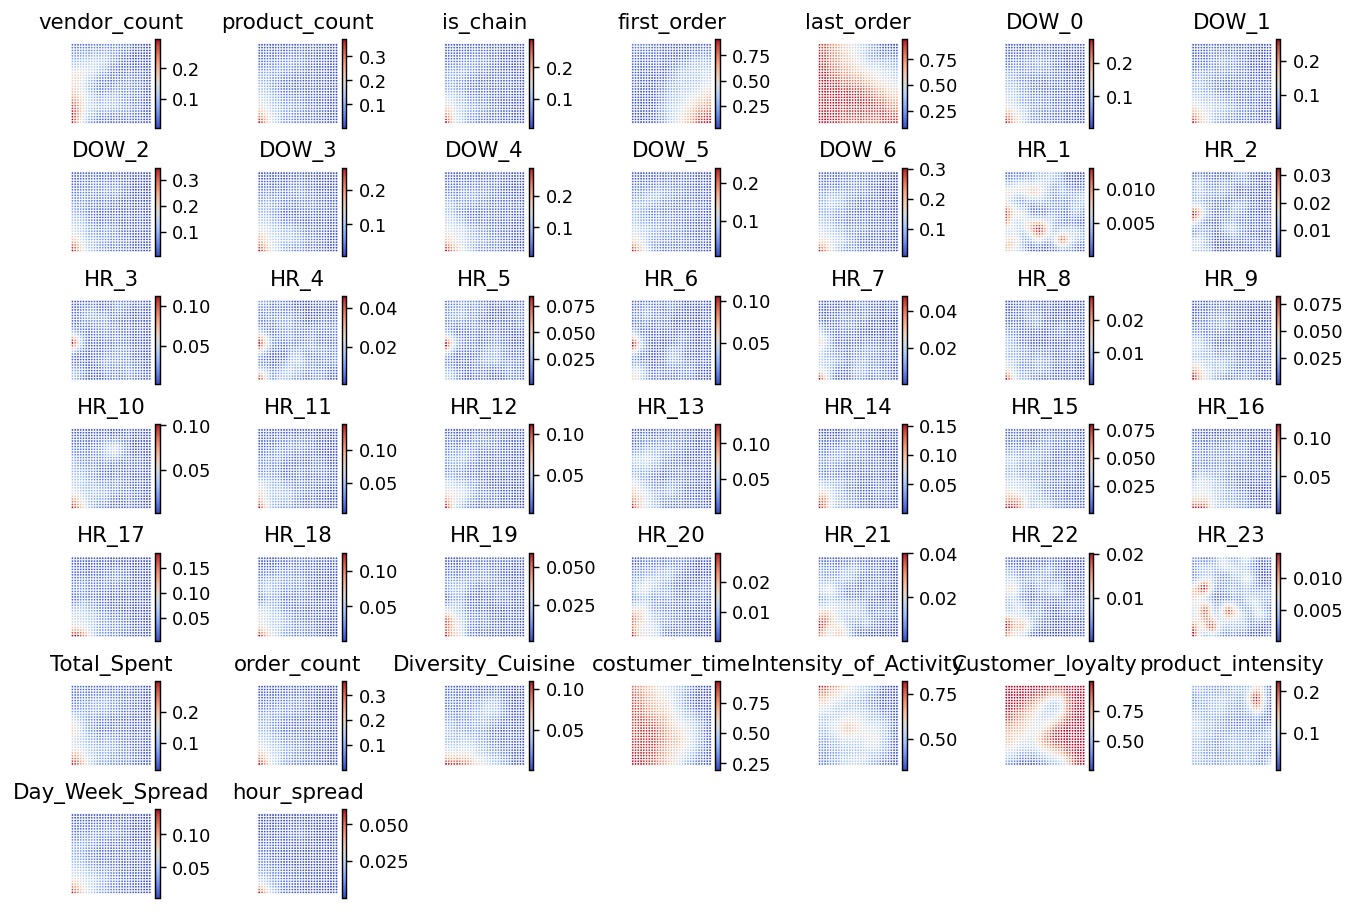

In [14]:
figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(7,7,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=metric_features[cpi],
                    cmap=cm.coolwarm,
                    )

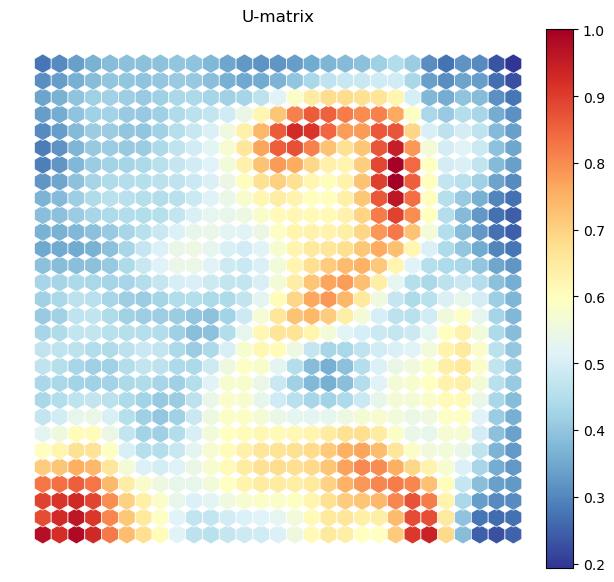

In [15]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    )

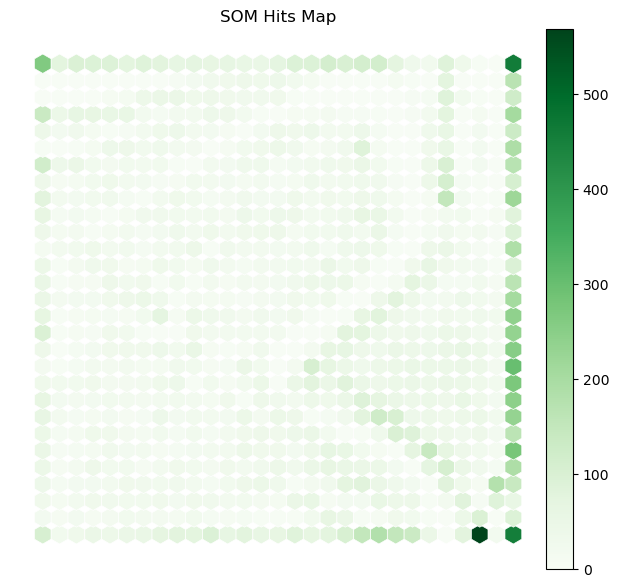

In [16]:
hitsmatrix = sm.activation_response(df[metric_features].values)


fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    )

In [14]:
weights_flat = sm.get_weights().reshape((29*29),len(df.columns))
weights_flat

array([[2.96313966e-01, 3.71141463e-01, 2.90114219e-01, ...,
        6.69934099e-02, 1.38004622e-01, 6.02449555e-02],
       [2.96174220e-01, 3.43600764e-01, 2.71914924e-01, ...,
        6.91448003e-02, 1.27759299e-01, 5.13554368e-02],
       [2.95831746e-01, 3.09152418e-01, 2.48231319e-01, ...,
        7.13502503e-02, 1.14459814e-01, 4.14951930e-02],
       ...,
       [5.01246013e-03, 2.79243179e-03, 1.06684492e-02, ...,
        1.80635434e-02, 3.99363375e-03, 1.11488274e-04],
       [4.87475632e-03, 2.61872723e-03, 1.07817698e-02, ...,
        1.59548996e-02, 4.01024605e-03, 1.10828340e-04],
       [4.91237713e-03, 2.50684411e-03, 1.08964672e-02, ...,
        1.39328681e-02, 4.05646671e-03, 1.11318194e-04]])

# K-means on top of SOM

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [19]:
cluster_range = range(2, 12)

# Lists to store evaluation metrics
inertia = []
avg_silhouette = []

# Iterate over the range of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=15, random_state=42)
    cluster_labels = kmeans.fit_predict(weights_flat)

    # Compute and store Inertia
    inertia.append(kmeans.inertia_)

    # Compute and store Average Silhouette Score
    silhouette_avg = silhouette_score(weights_flat, cluster_labels)
    avg_silhouette.append(silhouette_avg)

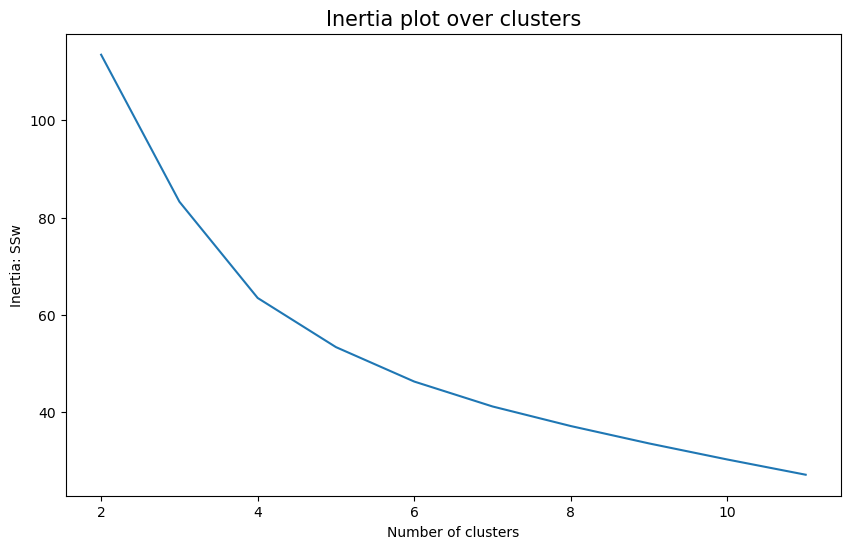

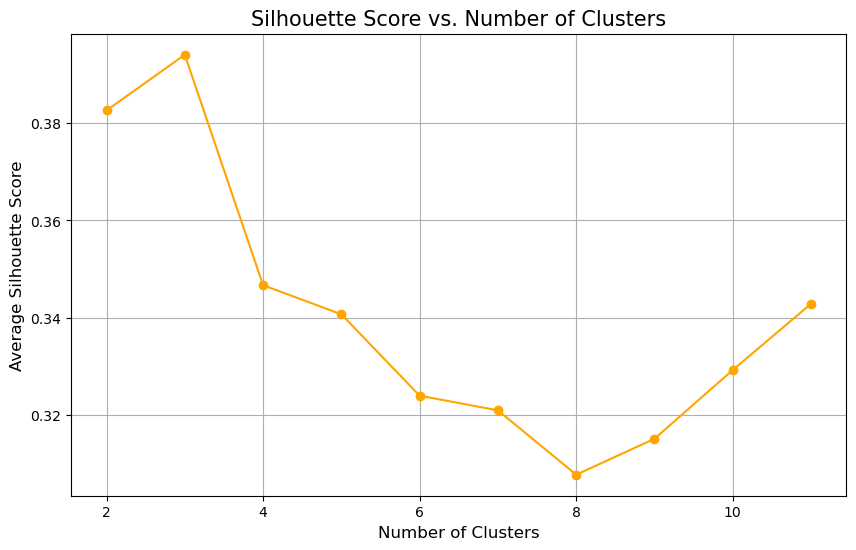

In [20]:
plt.figure(figsize=(10,6))
plt.plot(cluster_range, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

# Plot Average Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, avg_silhouette, marker='o', color='orange')
plt.title("Silhouette Score vs. Number of Clusters", size=15)
plt.xlabel("Number of Clusters", size=12)
plt.ylabel("Average Silhouette Score", size=12)
plt.grid(True)
plt.show()

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def tsne_visualization(data, cluster_column, title):
    # Separate features and labels
    features = data.drop(columns=[cluster_column])
    labels = data[cluster_column]

    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features_scaled)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title(f'T-SNE Visualization of {title}')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.show()

In [15]:
kmeans1 = KMeans(n_clusters=5, random_state=42)
kmeans_labels_SOM = kmeans1.fit_predict(weights_flat)
hclust_matrix = kmeans_labels_SOM.reshape((29,29))

d:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [16]:
nodes = weights_flat

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = kmeans_labels_SOM

In [17]:
bmu_index = np.array([sm.winner(x) for x in df[metric_features].values])

print(bmu_index.shape)

bmu_index

(30554, 2)


array([[24, 28],
       [28, 28],
       [19, 23],
       ...,
       [28, 26],
       [28, 27],
       [28, 27]])

In [18]:
som_final_labels_k = [hclust_matrix[i[0]][i[1]] for i in bmu_index]

In [19]:
df_final_k = pd.concat([
                df,
                pd.Series(som_final_labels_k, name='label', index=df.index)
            ], axis=1
            )

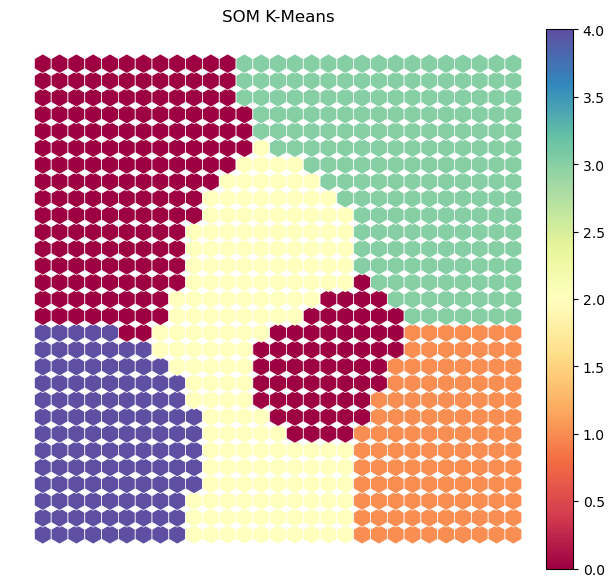

In [29]:
kmeans_matrix = kmeans_labels_SOM.reshape((29,29))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )

# Hierarchical on top of SOM

In [30]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit(weights_flat)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

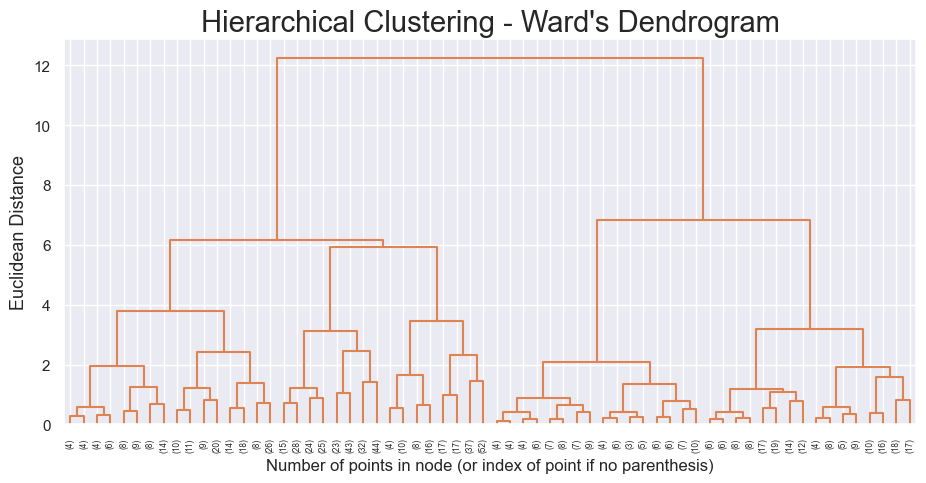

In [31]:
# Prepare variables
n_samples = len(weights_flat)
counts = np.zeros(hclust.children_.shape[0], dtype=int)
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [20]:
hierclust = AgglomerativeClustering(n_clusters=5, linkage='ward')
nodeclus_labels = hierclust.fit_predict(weights_flat)
hclust_matrix = nodeclus_labels.reshape((29,29))

In [21]:
som_final_labels = [hclust_matrix[i[0]][i[1]] for i in bmu_index]

In [22]:
df_final_hie = pd.concat([
                df,
                pd.Series(som_final_labels, name='label', index=df.index)
            ], axis=1
            )

# Results

In [27]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

r2_scores = []
r2_scores.append(r2(df_final_k, 'label'))
r2_scores.append(r2(df_final_hie, 'label'))
silhouette_avg_k=silhouette_score(df_final_k, df_final_k['label'])
silhouette_avg_h=silhouette_score(df_final_hie, df_final_hie['label'])

C:\Users\Casa-PC\AppData\Local\Temp/ipykernel_18064/2280191593.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw = np.sum(df.groupby(labels).apply(get_ss))
C:\Users\Casa-PC\AppData\Local\Temp/ipykernel_18064/2280191593.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw = np.sum(df.groupby(labels).apply(get_ss))


In [28]:
silhouette_scores = [silhouette_avg_k, silhouette_avg_h]

segments = ['k-means', 'hierarchical']

table = pd.DataFrame({
    'Segment': segments,
    'Silhouette Score': silhouette_scores,
    'r2 Score': r2_scores
})

print(table)

        Segment  Silhouette Score  r2 Score
0       k-means          0.630171  0.930446
1  hierarchical          0.610962  0.934733


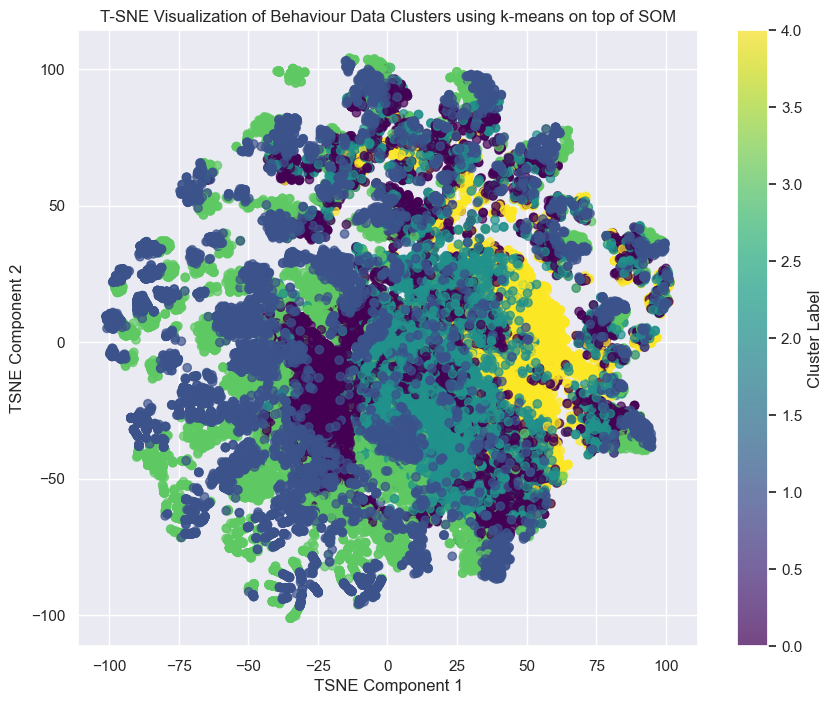

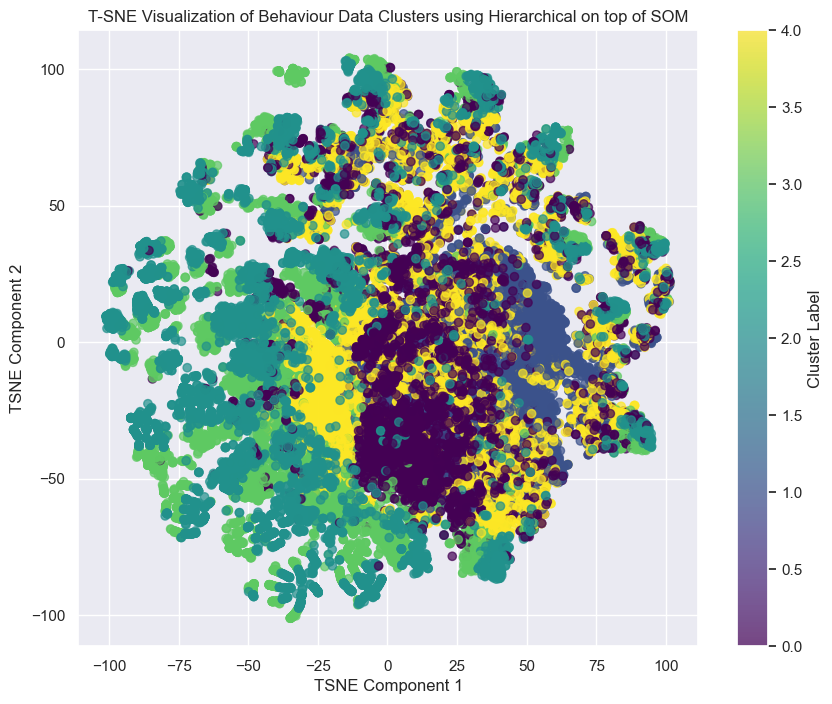

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Assuming df_psy and df_demo are already loaded DataFrames

def tsne_visualization(data, cluster_column, title):
    # Separate features and labels
    features = data.drop(columns=[cluster_column])
    labels = data[cluster_column]

    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features_scaled)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title(f'T-SNE Visualization of {title}')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.show()

# Visualize df_psy
tsne_visualization(df_final_k, cluster_column='label', title='Behaviour Data Clusters using k-means on top of SOM')

# Visualize df_demo
tsne_visualization(df_final_hie, cluster_column='label', title='Behaviour Data Clusters using Hierarchical on top of SOM')